In [6]:
import sys
import torch
sys.path.append('..')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

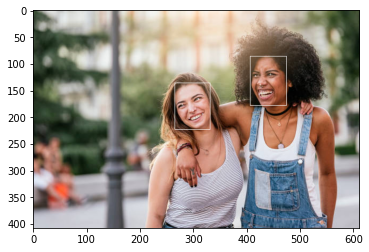

In [7]:
import facer

image = facer.hwc2bchw(facer.read_hwc('data/twogirls.jpg')
                       ).to(device=device)  # image: 1 x 3 x h x w

face_detector = facer.face_detector('retinaface/mobilenet', device=device)
with torch.inference_mode():
    faces = face_detector(image)

facer.show_bchw(facer.draw_bchw(image, faces))


In [8]:
face_parser = facer.face_parser('farl/lapa/448', device=device)


In [9]:
with torch.inference_mode():
    faces = face_parser(image, faces)


torch.Size([2, 11, 408, 612])


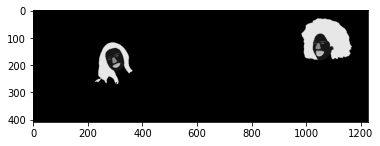

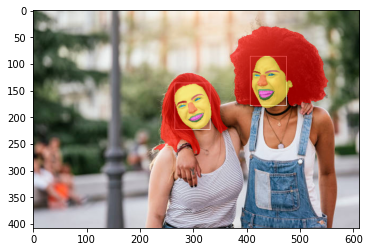

In [10]:
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
print(seg_probs.shape)
facer.show_bhw(seg_probs.argmax(dim=1).float()/seg_logits.size(1)*255)
facer.show_bchw(facer.draw_bchw(image, faces))
